In [ ]:
#Importing necessary packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from os import listdir

from PIL import Image
from os import listdir
import cv2
from matplotlib import image

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation,MaxPooling2D,Dropout
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from matplotlib import image
from keras.layers import GaussianNoise
import warnings
warnings.filterwarnings("ignore")

In [2]:
%cd C:\Users\praga\Downloads\ChromDownloads\

C:\Users\praga\Downloads\ChromDownloads


In [3]:
#Loading Good Images and Resizing them to (300,200) 

for filename in listdir('maskImages/good'):
    # load the image
    image = Image.open('maskImages/good/' + filename)
    image=image.resize((300,200))
    # save in jpeg format
    image.save('maskImages/goodResized/resize_' + filename)

In [4]:
#Loading Bad Images and Resizing them to (300,200) 

for filename in listdir('maskImages/bad'):
    # load the image
    image = Image.open('maskImages/bad/' + filename)
    image=image.resize((300,200))
    # save in jpeg format
    image.save('maskImages/badResized/resize_' + filename)

In [5]:
# load all images in a directory for good resized
from os import listdir
from matplotlib import image
# load all images in a directory
loaded_images_gray_good = list()
for filename in listdir('maskImages/goodResized'):
    # load image
    img_data = image.imread('maskImages/goodResized/' + filename)
    # store loaded image
    loaded_images_gray_good.append([img_data,"good"])
    #print('> loaded %s %s' % (filename, img_data.shape))

In [6]:
loaded_images_gray_good[0][0].shape

(200, 300, 3)

In [7]:
# load all images in a directory for bad resized
# load all images in a directory
loaded_images_gray_bad = list()
for filename in listdir('maskImages/badResized'):
    # load image
    img_data = image.imread('maskImages/badResized/' + filename)
    # store loaded image
    loaded_images_gray_bad.append([img_data,"bad"])
   # print('> loaded %s %s' % (filename, img_data.shape))

In [8]:
#Adding labels to the images as "good" for proper masked images and "bad" otherwise.
#Creating dataframe from the images and appending to form one dataframe for all images.
bad_im_df = pd.DataFrame(loaded_images_gray_bad)
bad_im_df.columns = ["Mask_Data","Label"]
good_im_df = pd.DataFrame(loaded_images_gray_good)
good_im_df.columns = ["Mask_Data","Label"]
df = good_im_df.append(bad_im_df,ignore_index=True)
df.columns = ['Mask_Data','Label']

In [9]:
#Verifying the count of good and bad images
df['Label'].value_counts()

bad     1000
good     970
Name: Label, dtype: int64

Splitting the data using Stratified shuffle split in 80:20 ratio, test set being 20%.
Keeping random state 42 to make the results reproducible.

In [10]:
split = StratifiedShuffleSplit(n_splits=6,test_size = 0.2,random_state = 42)
for train_idx,test_idx in split.split(df,df["Label"]):
    train_var = df.iloc[train_idx]
    test_var = df.iloc[test_idx]

Creating Validation set with 20% validation data using stratified split.

In [11]:
X_train,X_val,y_train,y_val = train_test_split(train_var["Mask_Data"],train_var["Label"],test_size=0.2,random_state=42)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(1260,) (316,) (1260,) (316,)


Converting Numerical labels into Categorical variables.

In [12]:
y_train_cat=[0]*len(y_train)
for i in range (0,len(y_train)):
    if y_train.iloc[i] == "good":
        y_train_cat[i]=[1];
    elif y_train.iloc[i] == "bad":
        y_train_cat[i]=[0];

In [13]:
y_val_cat=[0]*len(y_val)
for i in range (0,len(y_val)):
    if y_val.iloc[i] == "good":
        y_val_cat[i]=[1];
    elif y_val.iloc[i] == "bad":
        y_val_cat[i]=[0]

Converting y train into numpy arrays

In [14]:
y_train_ar=np.array(y_train_cat)
y_val_ar=np.array(y_val_cat)

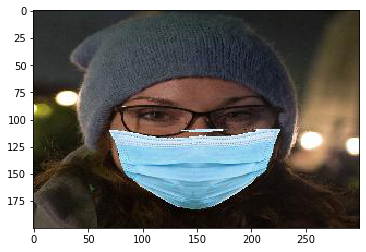

In [15]:
#Having a look at the image to see if it is decent enough for the model to be trained.
plt.imshow(df['Mask_Data'][0])
plt.show()

Converting the images to 4-D for applying CNN. Using reshape to do so.

In [16]:
X_train_lst =[0] * len(X_train) 
for i in range(0,len(X_train)):
    X_train_lst[i] = np.reshape((X_train.iloc[i]),(200,300,3))

X_train_ar = np.asarray(X_train_lst)
X_train_ar = X_train_ar.astype('float32')
X_train_ar /= 255

X_val_lst=[0] * len(X_val)
for i in range(0,len(X_val)):
    X_val_lst[i] = np.reshape((X_val.iloc[i]),(200,300,3))
    
X_val_ar = np.asarray(X_val_lst)
X_val_ar = X_val_ar.astype('float32')
X_val_ar /= 255


In [17]:
X_val_ar.shape

(316, 200, 300, 3)

Creating and Pre-processing test data by converting it to categorical and then numpy array.

In [31]:
X_test_data=test_var["Mask_Data"]
Y_test_data=test_var["Label"]

Converting target test set to Categorical Variable and making them numpy arrays

In [ ]:
Y_test_cat=[0]*len(Y_test_data)
for i in range (0,len(Y_test_data)):
    if Y_test_data.iloc[i] == 'good':
        Y_test_cat[i]=[1];
    elif Y_test_data.iloc[i] == 'bad':
        Y_test_cat[i]=[0];

Y_test_ar=np.array(Y_test_cat)

Converting X test data to 4-D and numpy array.

In [32]:
X_test_set_cat =[0] * len(X_test_data) 
for i in range(0,len(X_test_data)):
    X_test_set_cat[i] = np.reshape((X_test_data.iloc[i]),(200,300,3))

X_test_ar = np.asarray(X_test_set_cat)

X_test_ar = X_test_ar.astype('float32')
X_test_ar /= 255 


In [ ]:
#Building CNN model with Maxpooling, Dropout and "relu" as the activation function.

In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train_ar.shape[1:]))
model.add(GaussianNoise(0.1))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(GaussianNoise(0.1))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#model.add(Dense(2))
model.add(Dense(1, activation='sigmoid'))
#model.add(Activation('softmax'))

In [19]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy',patience=5, verbose=1, mode='max')

In [66]:
#fitting model
Model1=model.fit(X_train_ar, y_train_ar,
              batch_size=4,
              epochs=5,
              validation_data=(X_val_ar, y_val_ar),
              shuffle=True,callbacks=[es])

Epoch 1/5
315/315 [==============================] - 289s 918ms/step - loss: 0.3005 - accuracy: 0.9127 - val_loss: 0.1697 - val_accuracy: 0.9430
Epoch 2/5
315/315 [==============================] - 299s 948ms/step - loss: 0.1746 - accuracy: 0.9381 - val_loss: 0.0751 - val_accuracy: 0.9652
Epoch 3/5
315/315 [==============================] - 300s 951ms/step - loss: 0.1530 - accuracy: 0.9548 - val_loss: 0.1887 - val_accuracy: 0.9335
Epoch 4/5
315/315 [==============================] - 306s 970ms/step - loss: 0.1565 - accuracy: 0.9532 - val_loss: 0.0787 - val_accuracy: 0.9652
Epoch 5/5
315/315 [==============================] - 312s 991ms/step - loss: 0.0896 - accuracy: 0.9714 - val_loss: 0.0848 - val_accuracy: 0.9715


Plotting the learning curve.

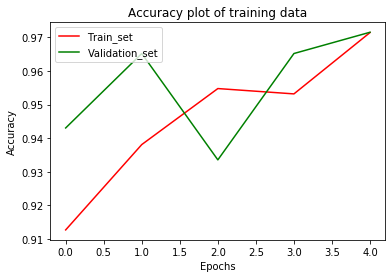

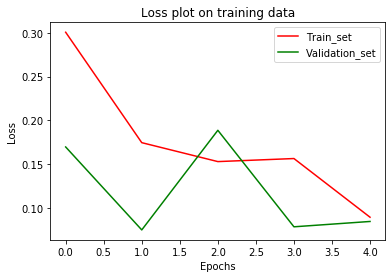

In [67]:
plt.plot(Model1.history['accuracy'], color='red')
plt.plot(Model1.history['val_accuracy'],color='green')
plt.title('Accuracy plot of training data')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train_set', 'Validation_set'], loc='upper left')
plt.show()

plt.plot(Model1.history['loss'], color='red')
plt.plot(Model1.history['val_loss'], color='green')
plt.title('Loss plot on training data')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train_set', 'Validation_set'], loc='upper right')
plt.show()

Plotting the Loss of model on training data

Evaluating the model on test set 

In [68]:
scores = model.evaluate(X_test_ar, Y_test_ar, verbose=True)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

13/13 [==============================] - 15s 1s/step - loss: 0.0712 - accuracy: 0.9721
Test loss: 0.07119321078062057
Test accuracy: 0.9720812439918518


Predicting using the model

In [69]:
y_pred=model.predict_classes(X_test_ar)

Checking the confusion matrix to see TP, TN, FP and FN.

In [70]:
confusion_matrix(Y_test_ar, y_pred)

array([[189,  11],
       [  0, 194]], dtype=int64)

Checking Precision and recall scores for the model

In [71]:
print('Precision score:%.2f'%precision_score(Y_test_ar, y_pred))
print('Recall score:%.2f'%recall_score(Y_test_ar, y_pred))

Precision score:0.95
Recall score:1.00


Trying diff model by adding layers

In [72]:
model1 = Sequential()

model1.add(Conv2D(16, (3, 3), padding='same', input_shape=X_train_ar.shape[1:]))
model1.add(GaussianNoise(0.2))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train_ar.shape[1:]))
model1.add(GaussianNoise(0.2))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(GaussianNoise(0.1))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))


model1.add(Flatten())
model1.add(Dense(50))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
#model1.add(Dense(2))
model1.add(Dense(1, activation='sigmoid'))
#model1.add(Activation('softmax'))

In [74]:
model1.compile(loss='binary_crossentropy',metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_accuracy',patience=2, verbose=1, mode='max',restore_best_weights=True)

In [75]:
#fitting model
Model2=model1.fit(X_train_ar, y_train_ar,
              batch_size=4,
              epochs=5,
              validation_data=(X_val_ar, y_val_ar),
              shuffle=True,callbacks=[early_stop])

Epoch 1/5
315/315 [==============================] - 93s 296ms/step - loss: 0.8031 - accuracy: 0.4865 - val_loss: 0.6925 - val_accuracy: 0.5665
Epoch 2/5
315/315 [==============================] - 97s 309ms/step - loss: 0.6985 - accuracy: 0.4921 - val_loss: 0.6928 - val_accuracy: 0.5665
Epoch 3/5
315/315 [==============================] - 99s 313ms/step - loss: 0.6552 - accuracy: 0.5690 - val_loss: 0.4392 - val_accuracy: 0.8829
Epoch 4/5
315/315 [==============================] - 99s 314ms/step - loss: 0.2960 - accuracy: 0.9056 - val_loss: 0.2506 - val_accuracy: 0.9114
Epoch 5/5
315/315 [==============================] - 101s 320ms/step - loss: 0.1748 - accuracy: 0.9349 - val_loss: 0.2257 - val_accuracy: 0.9810


In [76]:
scores = model1.evaluate(X_test_ar, Y_test_ar, verbose=True)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

13/13 [==============================] - 3s 267ms/step - loss: 0.2478 - accuracy: 0.9467
Test loss: 0.2478186935186386
Test accuracy: 0.9467005133628845


In [77]:
y_pred1=model1.predict_classes(X_test_ar)

In [78]:
confusion_matrix(Y_test_ar, y_pred1)

array([[193,   7],
       [ 14, 180]], dtype=int64)

In [79]:
print('Precision score:%.2f'%precision_score(Y_test_ar, y_pred1))
print('Recall score:%.2f'%recall_score(Y_test_ar, y_pred1))

Precision score:0.96
Recall score:0.93
